In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("..")

import os
os.environ['D4RL_SUPPRESS_IMPORT_ERROR'] = '1'
os.environ['LD_LIBRARY_PATH'] = '/home/nazar/.mujoco/mujoco210/bin:/usr/lib/nvidia'

import gym
import d4rl

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib import patches

import equinox as eqx
import jax
import jax.numpy as jnp
import functools

from tqdm.auto import tqdm
from jaxrl_m.common import TrainStateEQX
from src.agents.iql_equinox import GaussianPolicy, GaussianIntentPolicy

from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools import plot, sinkhorn_divergence
from ott.solvers.linear import implicit_differentiation as imp_diff

import optax

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None))
def eval_ensemble_psi(ensemble, s):
    return eqx.filter_vmap(ensemble.psi_net)(s)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None))
def eval_ensemble_phi(ensemble, s):
    return eqx.filter_vmap(ensemble.phi_net)(s)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None))
def eval_ensemble_icvf_viz(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.classic_icvf_initial)(s, g, z)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None)) # V(s, g, z), g - dim 29, z - dim 256
def eval_ensemble_icvf_latent_z(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.classic_icvf)(s, g, z)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None)) # V(s, g ,z ), g, z - dim 256
def eval_ensemble_icvf_latent_zz(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.icvf_zz)(s, g, z)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, z=None)) 
def eval_ensemble_gotil(ensemble, s, z):
    return eqx.filter_vmap(ensemble.gotil)(s, z)

@eqx.filter_jit
def get_gcvalue(agent, s, g, z):
    v_sgz_1, v_sgz_2 = eval_ensemble_icvf_viz(agent.value_learner.model, s, g, z)
    return (v_sgz_1 + v_sgz_2) / 2

def get_v_gz(agent, initial_state, target_goal, observations):
    initial_state = jnp.tile(initial_state, (observations.shape[0], 1))
    target_goal = jnp.tile(target_goal, (observations.shape[0], 1))
    return -1 * get_gcvalue(agent, initial_state, observations, target_goal)
    
def get_v_zz(agent, goal, observations):
    goal = jnp.tile(goal, (observations.shape[0], 1))
    return get_gcvalue(agent, observations, goal, goal)

@eqx.filter_vmap(in_axes=dict(agent=None, obs=None, goal=0))
def get_v_zz_heatmap(agent, obs, goal): # goal - whole traj
    goal = jnp.tile(goal, (obs.shape[0], 1))
    return get_gcvalue(agent, obs, goal, goal)



pybullet build time: May 20 2022 19:45:31
/home/nazar/anaconda3/envs/icvf/lib/python3.9/site-packages/flax/linen/module.py:77: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys.
  KeyArray = Union[jax.Array, jax.random.KeyArray]  # pylint: disable=invalid-name
/home/nazar/anaconda3/envs/icvf/lib/python3.9/site-packages/flax/linen/recurrent.py:45: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys.
  PRNGKey = jax.random.KeyArray
/home/nazar/anaconda3/envs/icvf/lib/python3.9/site-packages/flax/linen/stochastic.py:28: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys.
  KeyArray = Union[jax.

In [2]:
import os
os.environ['D4RL_SUPPRESS_IMPORT_ERROR'] = '1'
os.environ['LD_LIBRARY_PATH'] = '/home/nazar/.mujoco/mujoco210/bin:/usr/lib/nvidia'
os.environ['CUDA_VISIBLE_DEVICES']='1,2,3'

jax.devices()

[gpu(id=0), gpu(id=1), gpu(id=2)]

In [4]:
env = gym.make("antmaze-large-diverse-v2")
d4rl_ds = d4rl.qlearning_dataset(env)

dones_float = np.zeros_like(d4rl_ds['rewards'])
for i in range(len(dones_float) - 1):
    if np.linalg.norm(d4rl_ds['observations'][i + 1] - d4rl_ds['next_observations'][i]) > 1e-6 or d4rl_ds['terminals'][i] == 1.0:
        dones_float[i] = 1
    else:
        dones_float[i] = 0
dones_float[-1] = 1
d4rl_ds['dones_float'] = dones_float


from src.gc_dataset import GCSDataset, GCDataset
from src.d4rl_utils import get_dataset
import dataclasses

%matplotlib inline
%load_ext autoreload
%autoreload 2

# expert_trajectory = d4rl_ds['observations'][np.arange(start=1000, stop=1350)] #[np.arange(start=10000, stop=10190)]
expert_trajectory = np.load("/home/m_bobrin/AILOT/expert_traj.npz", allow_pickle=True)['arr_0']

dataset = get_dataset(env)
gcsds_params = {"p_currgoal": 0.1, "p_trajgoal":0.3, "discount": 0.999, "geom_sample": True, "high_p_middlegoal": 0.5, "way_steps": 15}

gc_dataset = GCSDataset(dataset, **gcsds_params, expert_trajectory=expert_trajectory)



Target Goal:  (32.95733202470426, 24.20571069149326)


load datafile:  12%|█▎        | 1/8 [00:00<00:01,  3.85it/s]

load datafile: 100%|██████████| 8/8 [00:02<00:00,  3.37it/s]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


load datafile: 100%|██████████| 8/8 [00:02<00:00,  3.38it/s]


In [5]:
expert_trajectory = np.load("/home/m_bobrin/AILOT/expert_traj.npz", allow_pickle=True)['arr_0']
expert_trajectory = expert_trajectory.tolist()["observations"]
gc_dataset.expert_trajectory = expert_trajectory
print(expert_trajectory.shape)

(524, 29)


In [6]:
from src.agents import icvf
%cd /home/nazar/PycharmProjects/AILOT
icvf_model = icvf.create_eqx_learner(seed=42,
                                     observations=d4rl_ds['observations'][0],
                                     hidden_dims=[256, 256],
                                     load_pretrained_icvf=True)

/home/nazar/PycharmProjects/AILOT
Extra kwargs: {}


In [23]:
from abc import ABC, abstractmethod
from jax.numpy import ndarray
from ott.geometry import costs
from ott.math import utils as mu

@jax.tree_util.register_pytree_node_class
class MyCost(costs.CostFn):
    def __init__(self) -> None:
        super().__init__()
        self.cost = costs.SqEuclidean()

    def pairwise(self, x: ndarray, y: ndarray) -> float:
        d = self.cost(x, y)
        return jnp.minimum(5000, d)


class OTRewardsExpert:

    def __init__(
        self, expert_states,
    ):
        self.expert_states = expert_states
        self.expert_z = eval_ensemble_psi(icvf_model.value_learner.model, expert_states).mean(axis=0)
        self.sub_steps = 5

    def make_subs(self, z, sub_steps):
        sub_indx = jnp.minimum(jnp.arange(0, z.shape[0]) + sub_steps, z.shape[0] - 1)
        return jax.tree_map(lambda arr: arr[sub_indx], z)
    

    @eqx.filter_jit
    def get_z_and_start_index(self, obs):

        z = eval_ensemble_psi(icvf_model.value_learner.model, obs).mean(axis=0)
        diff = z[0][jnp.newaxis,] - self.expert_z
        i_min = jnp.argmin((diff ** 2).sum(-1)).squeeze()

        return z, i_min

    def compute_rewards(
        self,
        observations: np.ndarray,
        dones_float: np.ndarray,
    ):
        i0 = 0
        rewards = []
        selected_index = []

        for i1 in tqdm(np.where(dones_float > 0.5)[0].tolist()):
            if i1 - i0 > 10:
                zi, start_index = self.get_z_and_start_index(observations[i0:i1+1])
                ri = self.compute_rewards_one_episode(zi, self.expert_z[start_index:])
                print(ri.min(), ri.mean(), ri.max())
                rewards.append(jax.device_get(ri))
                selected_index.append([i0, i1 + 1])
            i0 = i1 + 1
                  
        return np.concatenate(rewards), selected_index

    
    @eqx.filter_jit
    def compute_rewards_one_episode(
        self, episode_obs, expert_obs
    ):

        za_1 = episode_obs
        za_2 = self.make_subs(za_1, self.sub_steps)
        x = jnp.concatenate([za_1, za_2], axis=1) 

        ze_1 = expert_obs
        ze_2 = self.make_subs(ze_1, self.sub_steps)
        y = jnp.concatenate([ze_1, ze_2], axis=1) 

        geom = pointcloud.PointCloud(x, y, epsilon=0.001)
        ot_prob = linear_problem.LinearProblem(geom)
        solver = sinkhorn.Sinkhorn(max_iterations=1200, use_danskin=True)

        ot_sink = solver(ot_prob)
        transp_cost = jnp.sum(ot_sink.matrix * geom.cost_matrix, axis=1)
        rewards = -transp_cost * episode_obs.shape[0] / 10

        return rewards

    @eqx.filter_jit
    def compute_rewards_unbalanced(
        self, episode_obs, episode_subs
    ):

        za_1 = eval_ensemble_psi(icvf_model.value_learner.model, episode_obs).mean(axis=0)
        za_2 = eval_ensemble_psi(icvf_model.value_learner.model, episode_subs).mean(axis=0)
        x = jnp.concatenate([za_1, za_2], axis=1) 

        ze_1 = self.expert_z
        ze_2 = self.make_subs(ze_1, self.sub_steps)
        y = jnp.concatenate([ze_1, ze_2], axis=1) 

        geom = pointcloud.PointCloud(x, y, epsilon=0.001)
        ot_prob = linear_problem.LinearProblem(geom)
        solver = sinkhorn.Sinkhorn(max_iterations=1200, use_danskin=True)

        ot_sink = solver(ot_prob)
        transp_cost = jnp.sum(ot_sink.matrix * geom.cost_matrix, axis=1)
        rewards = -transp_cost * episode_obs.shape[0] / 10

        return rewards

In [8]:

print(gc_dataset.dataset['observations'].shape[0], d4rl_ds['terminals'].shape[0])
expert = OTRewardsExpert(expert_trajectory)
rewards, selected_index = expert.compute_rewards(gc_dataset.dataset["observations"], gc_dataset.dataset['dones_float'])

999000 999000


  0%|          | 0/7182 [00:00<?, ?it/s]

-18.393862 -14.532156 -4.8413343
-20.990606 -13.343205 -0.5623807
-20.468596 -12.055405 -0.862604
-14.052952 -8.237952 -0.25546595
-18.89021 -13.455906 -7.2823896
-19.810236 -4.448433 -0.2089255
-15.345486 -7.953696 -0.33418438
-22.75472 -15.248768 -7.1656585
-28.46058 -16.849873 -3.625895
-18.44517 -14.790735 -0.38215312
-20.028622 -10.947461 -0.42303765
-21.024809 -17.064463 -6.497895
-19.835732 -11.5079975 -1.1364672
-28.401894 -19.99867 -0.88502926
-26.905787 -13.978495 -0.4774564
-27.358675 -17.79745 -0.57755053
-14.438184 -8.110382 -0.5740584
-20.006962 -12.172246 -0.22566682
-20.169983 -7.4909167 -0.19522999
-21.996704 -11.874518 -0.024786245
-14.819196 -11.286594 -0.16152963
-21.370752 -15.417124 -0.4416031
-21.882477 -6.707854 -0.09626929
-12.840455 -3.7621515 -0.42984977
-13.906527 -10.052733 -0.6214448
-15.199859 -7.403889 -0.17340215
-21.0113 -13.682352 -0.087969504
-11.805369 -6.766196 -3.7816155
-16.941586 -9.386959 -0.1498026
-19.177208 -6.6305237 -0.22824928
-19.999578 

In [9]:
rewards.min(), rewards.max()


(-32.21024, 9.155272e-06)

In [10]:
selected_index = np.asarray(selected_index)
from jaxrl_m.dataset import Dataset

class ExpRewardsScaler:
    def init(self, rewards: np.ndarray):
        self.min = np.quantile(np.abs(rewards).reshape(-1), 0.0)
        self.max = np.quantile(np.abs(rewards).reshape(-1), 0.95)

    def scale(self, rewards: np.ndarray):
        # From paper
        return  5 * np.exp( rewards / self.max) - 2.1 + 0.5  - 0.7


def get_subs(dataset: GCSDataset, add_steps: int):
    terminal_locs = dataset.terminal_locs
    indx = np.arange(dataset.dataset['observations'].shape[0])
    final_state_indx = terminal_locs[np.searchsorted(terminal_locs, indx)] 
    way_indx = np.minimum(indx + add_steps, final_state_indx)
    subs = jax.tree_map(lambda arr: arr[way_indx], dataset.dataset['observations'])
    return subs


sq_rewards = -jnp.sqrt(-rewards+0.0001)
scaler = ExpRewardsScaler()
scaler.init(sq_rewards)
scaled_rewards = scaler.scale(sq_rewards).astype(np.float32)
ds = gc_dataset.dataset
print(jnp.quantile(scaled_rewards, 0.1), jnp.quantile(scaled_rewards, 0.5), jnp.quantile(scaled_rewards, 0.9))

r_min = jnp.quantile(scaled_rewards, 0.9)

scaled_rewards[scaled_rewards < r_min] = r_min

subs_15 = get_subs(gc_dataset, 15)
subs_10 = get_subs(gc_dataset, 10)
subs_5 = get_subs(gc_dataset, 5)

ds = gc_dataset.dataset

data_with_ot_rewards = Dataset(
    observations = np.concatenate([ds['observations'][i:j] for i, j in selected_index]).astype(np.float32)[scaled_rewards > r_min],
    next_observations = np.concatenate([ds['next_observations'][i:j] for i, j in selected_index]).astype(np.float32)[scaled_rewards > r_min],
    actions = np.concatenate([ds['actions'][i:j] for i, j in selected_index]).astype(np.float32)[scaled_rewards > r_min],
    rewards = scaled_rewards[scaled_rewards > r_min],
    masks=1.0 - np.concatenate([ds['dones_float'][i:j] for i, j in selected_index]).astype(np.float32)[scaled_rewards > r_min],
    sub_observations_5=np.concatenate([subs_5[i:j] for i, j in selected_index]).astype(np.float32)[scaled_rewards > r_min], 
    sub_observations_10=np.concatenate([subs_10[i:j] for i, j in selected_index]).astype(np.float32)[scaled_rewards > r_min], 
    sub_observations_15=np.concatenate([subs_15[i:j] for i, j in selected_index]).astype(np.float32)[scaled_rewards > r_min], 
)


-0.4041722 -0.008852184 1.4962968


In [26]:
obs = data_with_ot_rewards["observations"]
subs = data_with_ot_rewards["sub_observations_5"]
print(obs.shape)
expert = OTRewardsExpert(expert_trajectory)
rewards_unb = expert.compute_rewards_unbalanced(obs, subs)

print(jnp.quantile(rewards_unb, 0.1), jnp.quantile(rewards_unb, 0.5), jnp.quantile(rewards_unb, 0.9))

sq_rewards = -jnp.sqrt(-rewards_unb+0.0001)
scaler = ExpRewardsScaler()
scaler.init(sq_rewards)
scaled_rewards = scaler.scale(sq_rewards).astype(np.float32)

print(jnp.quantile(scaled_rewards, 0.1), jnp.quantile(scaled_rewards, 0.5), jnp.quantile(scaled_rewards, 0.9))


data_with_ot_rewards_2 = Dataset(
    observations = data_with_ot_rewards["observations"],
    next_observations = data_with_ot_rewards["next_observations"],
    actions = data_with_ot_rewards["actions"],
    masks = data_with_ot_rewards["masks"],
    sub_observations_5= data_with_ot_rewards["sub_observations_5"],
    sub_observations_10= data_with_ot_rewards["sub_observations_10"],
    rewards = scaled_rewards,
    
)

(99169, 29)
-1.210653 -0.65339464 -0.2514056
-0.3753953 0.17944366 0.9358967


In [38]:
from src.agents.iql.common import Batch


from src.agents.iql.learner import Learner

z_sample = eval_ensemble_psi(icvf_model.value_learner.model, env.observation_space.sample()[np.newaxis]).mean(axis=0)

iql_agent = Learner(
        42,
        env.observation_space.sample()[np.newaxis],
        z_sample,
        max_steps=500_000,
        expectile=0.9,
        temperature=3)

@eqx.filter_jit
def get_z(obs):
    return eval_ensemble_psi(icvf_model.value_learner.model, obs).mean(axis=0)

pbar = tqdm(range(500_000))
expert = OTRewardsExpert(expert_trajectory)

for i in pbar:
    sample = data_with_ot_rewards_2.sample(256)

    if i % 3 == 0:
        subs_i = sample["sub_observations_5"]
    elif i % 3 == 1:
        subs_i = sample["sub_observations_5"]
    else:
        subs_i = sample["sub_observations_10"]

    z = get_z(subs_i)
    
    batch = Batch(
        observations=sample["observations"],
        next_observations=sample["next_observations"],
        actions = z / 10,
        rewards= sample["rewards"],
        masks= sample["masks"]
    )
    update_info = iql_agent.update(batch)
    if i % 100 == 0:
        update_info["adv"] = None

        expert_z = get_z(expert_trajectory)
        expert_sub_z = expert.make_subs(expert_z, 5)
        pred_subs = iql_agent.sample_actions(expert_trajectory, temperature=0) * 10
        update_info["eval"] = (jnp.abs(pred_subs - expert_sub_z).mean())

        pbar.set_postfix(update_info)
    


  0%|          | 0/500000 [00:00<?, ?it/s]

In [43]:
from tqdm.auto import tqdm
from jaxrl_m.common import TrainStateEQX
from src.agents.iql_equinox import GaussianPolicy, GaussianIntentPolicy

def update_low_actor(iql_agent, batch_size, iter_num):
    
    key = jax.random.PRNGKey(42)
    actor_learner = TrainStateEQX.create(
            model=GaussianPolicy(key=key,
                                 hidden_dims=[512, 512, 512],
                                 state_dim=env.observation_space.shape[0],
                                 intents_dim=256,
                                 action_dim=env.action_space.shape[0]),
            optim=optax.adam(learning_rate=1e-3)
        )
    def optimize_actor(actor_learner, sample, cur_goals_z, key):
        v = eval_ensemble_icvf_latent_zz(icvf_model.value_learner.model, sample['observations'], cur_goals_z, cur_goals_z).mean(0)
        nv = eval_ensemble_icvf_latent_zz(icvf_model.value_learner.model, sample['next_observations'], cur_goals_z, cur_goals_z).mean(0)
        adv = nv - v
        exp_a = jnp.minimum(jnp.exp(adv * 10.0), 100.0)
        actor_dist = eqx.filter_vmap(actor_learner)(sample['observations'], cur_goals_z)
        log_prob = actor_dist.log_prob(sample['actions'])
        loss = -(exp_a * log_prob).mean()
        return loss, adv.mean()

    
    actor_loss_fn = eqx.filter_jit(eqx.filter_value_and_grad)(optimize_actor, has_aux=True)
    
    @eqx.filter_jit
    def make_step(actor_learner, sample, cur_goals_z, key):
        (loss, adv), grads = actor_loss_fn(actor_learner.model, sample, cur_goals_z, key)
        actor_learner = actor_learner.apply_updates(grads)
        return actor_learner, loss, adv

        
    pbar = tqdm(range(iter_num))
    for i in pbar:
        sample = data_with_ot_rewards_2.sample(batch_size)
        key, sample_key = jax.random.split(key, 2)
        cur_goals_z = iql_agent.sample_actions(sample['observations'], temperature=0) * 10
        actor_learner, loss, adv = make_step(actor_learner, sample, cur_goals_z, key=sample_key)
        # actor_learner, loss, adv = make_step_2(actor_learner, sample, key=sample_key)
        if i % 500 == 0:
            pbar.set_postfix({"Loss": loss, "Adv": adv})
            
    return actor_learner
    
updated_actor = update_low_actor(iql_agent, batch_size=512, iter_num=50_000)

  0%|          | 0/50000 [00:00<?, ?it/s]

Target Goal:  (32.0957953382089, 24.96560099085557)
Target Goal:  (31.845472, 24.854422)
0.0
V(next_s, g, z)= [-51.107956]
V(s, g, z)= [-51.58686]
Advantage of going to sg from s:  [0.47890472]


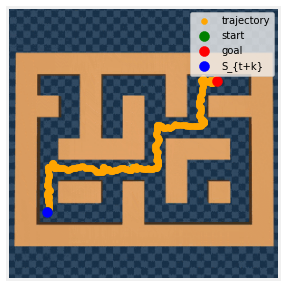

0.0
V(next_s, g, z)= [-43.397484]
V(s, g, z)= [-44.38687]
Advantage of going to sg from s:  [0.9893875]


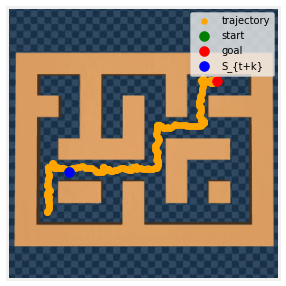

0.0
V(next_s, g, z)= [-41.02562]
V(s, g, z)= [-43.395462]
Advantage of going to sg from s:  [2.3698425]


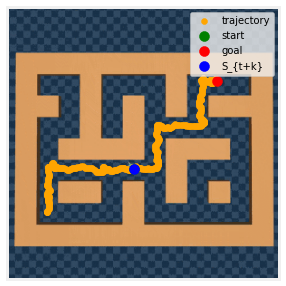

0.0
V(next_s, g, z)= [-36.804726]
V(s, g, z)= [-36.72473]
Advantage of going to sg from s:  [-0.0799942]


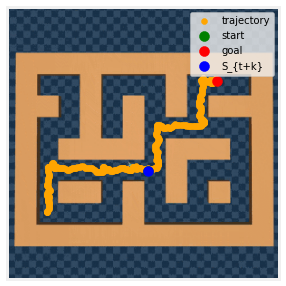

0.0
V(next_s, g, z)= [-20.990532]
V(s, g, z)= [-19.61168]
Advantage of going to sg from s:  [-1.3788528]


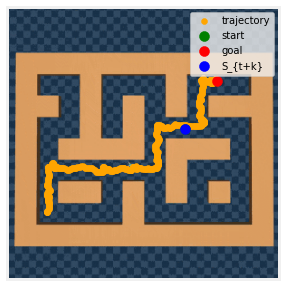

1.0


In [44]:
from gymnasium.utils import save_video

scales_shifts = [(6, 40), (-6, 230)]
def scale_and_shift(x, lst):
    return lst[0] * x + lst[1]
    
def plot_traj_image(traj, start, goal, subgoals, bgpath):
    fig, ax = plt.subplots(figsize=(5, 5))
    pimage = plt.imread(bgpath)
    ax.imshow(pimage)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(scale_and_shift(expert_trajectory[:, 0], scales_shifts[0]), scale_and_shift(expert_trajectory[:, 1], scales_shifts[1]), alpha=1, label='trajectory', color='orange')
    ax.scatter(scale_and_shift(start[0], scales_shifts[0]), scale_and_shift(start[1], scales_shifts[1]), c='g', s=100, label='start')
    ax.scatter(scale_and_shift(goal[0], scales_shifts[0]), scale_and_shift(goal[1], scales_shifts[1]), c='r', s=100, label='goal')
    ax.scatter(scale_and_shift(subgoals[0], scales_shifts[0]), scale_and_shift(subgoals[1], scales_shifts[1]), c='b', s=100, label='S_{t+k}')
    ax.legend(fontsize=10)

sample = gc_dataset.sample(1)
start_point = expert_trajectory[0]
target_goal = expert_trajectory[-1] #sample['ailot_high_goals'][0]
sample_key = jax.random.PRNGKey(42)

# env.env.env._wrapped_env.viewer.cam.lookat[0] = 18
# env.env.env._wrapped_env.viewer.cam.lookat[1] = 12
# env.env.env._wrapped_env.viewer.cam.distance = 50
# env.env.env._wrapped_env.viewer.cam.elevation = -90
env.reset()
env.env.env._wrapped_env.set_xy((start_point[0], start_point[1]))
env.env.env._wrapped_env.set_target((target_goal[0], target_goal[1]))
start_point = env.env.env._wrapped_env._get_obs()
curr_point = start_point
frames=[]

i = 0
done = False
while not done:
    key, sample_key = jax.random.split(sample_key, 2)
    # intent = updated_actor_intents_learner_2.model(curr_point).sample(seed=key)
    intent = jax.device_get(iql_agent.sample_actions(curr_point.squeeze(), temperature=0)) * 10
    action = jax.device_get(updated_actor.model(curr_point.squeeze(), intent.squeeze()).sample(seed=key))
    action = jnp.clip(action, -1, 1)
    new_obs, reward, done ,_ = env.step(action)
    
    os.environ['CUDA_VISIBLE_DEVICES']='4'
    frames.append(env.render(mode='rgb_array'))
    os.environ['CUDA_VISIBLE_DEVICES']='1,2,3'
    if done:
        print(reward)
    if i % 100 == 0:
        print(reward)
        Vnsgz = eval_ensemble_icvf_viz(icvf_model.value_learner.model, curr_point[None], target_goal[None], target_goal[None]).mean(0)
        Vsgz = eval_ensemble_icvf_viz(icvf_model.value_learner.model, new_obs[None], target_goal[None], target_goal[None]).mean(0)
        print("V(next_s, g, z)=", Vnsgz)
        print("V(s, g, z)=", Vsgz)
        print("Advantage of going to sg from s: ", Vnsgz - Vsgz)
        
        plot_traj_image(sample, new_obs, target_goal, new_obs, "/home/m_bobrin/AILOT/notebooks/antmaze-large.png")

        plt.show()
    curr_point = new_obs
    i+=1
# save_video.save_video(frames, video_folder='.', fps=env.env.env._wrapped_env.metadata['render_fps'])